### Notas
- En este momento el dataset está desequilibrado, hay un 13% de casos positivos. La precisión del modelo llega a 90%, sin embargo es posible que la precisión real sea menor dado que el modelo suele predecir no agresividad.

#### Imports

In [1]:
import os
import glob
import numpy as np
# import keras
import librosa
import random

from sklearn.model_selection import train_test_split
from scipy.signal import lfilter, butter
from scipy.io.wavfile import read,write
import sys
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import *
import matplotlib.pyplot as plt

#### Data Augmentation

In [2]:

def add_noise(data):
    max_amp = 0.15
    rand_amp = random.randrange(80,100) / (100 / max_amp)
    noise_amp = rand_amp*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data
    
def augment_data(audio):
    noise_audio = add_noise(audio)
    return noise_audio
    

#### Feature extraction

In [31]:
def get_mfccs(y, sr):

    mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40)
    # mfcc_mean = np.mean(librosa.feature.mfcc(y=y, sr=sr, n_mfcc=40).T,axis=0)
    # mfcc_delta1_mean = np.mean(librosa.feature.delta(mfcc).T,axis=0)
    # mfcc_delta2_mean = np.mean(librosa.feature.delta(mfcc, order=2).T,axis=0)
    mfcc_delta1 = librosa.feature.delta(mfcc)
    mfcc_delta2 = librosa.feature.delta(mfcc)
    return (mfcc, mfcc_delta1, mfcc_delta2)

def extract_features(y, sr):
    mfccs = np.zeros((3, 40))
    mfcc = get_mfccs(y, sr)
    mfcc = cmv_normalization(*mfcc)
    
    mfccs[0, :] = mfcc[0]
    mfccs[1, :] = mfcc[1]
    mfccs[2, :] = mfcc[2]
    
    features = mfccs
    return features
def cmv_normalization(mfcc, mfcc_delta1, mfcc_delta2): #  Cepstral mean and variance normalization. Leer el paper respecto a esto para encontrar alternativas que puedan llegar a ser mejores.
    mean = np.mean(mfcc)
    std = np.std(mfcc)
    mfcc = (mfcc - mean) / std
    mfcc = np.mean(mfcc.T,axis=0)

    mean_delta1 = np.mean(mfcc_delta1)
    std_delta1 = np.std(mfcc_delta1)
    mfcc_delta1 = (mfcc_delta1 - mean_delta1) / std_delta1
    mfcc_delta1 = np.mean(mfcc_delta1.T,axis=0)

    mean_delta2 = np.mean(mfcc_delta2)
    std_delta2 = np.std(mfcc_delta2)
    mfcc_delta2 = (mfcc_delta2 - mean_delta2) / std_delta2
    mfcc_delta2 = np.mean(mfcc_delta2.T,axis=0)
    return [mfcc, mfcc_delta1, mfcc_delta2]

#### Speaker diarization

In [4]:
def speaker_diarization():
    pass

#### pre-processing

In [14]:
def denoise():
    pass

def butter_params(fs, order=5):
    nyq = 0.5 * fs
    low_freq = 300
    high_freq = 3300
    low = low_freq / nyq
    high = high_freq / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def butter_bandpass_filter(audio, fs, order=5):
    b, a = butter_params(fs, order=order)
    y = lfilter(b, a, audio)
    return y

In [32]:
input_shape = (3, 40)
dataset_name = './dataset_CNN_noise_CMVN_mp3.npy'
directories = glob.glob(
        "/home/francoj/Documentos/Reconocimiento de emociones/Post Medium/Data//Actor_*//*.mp3"
    )

num_of_files = len(directories)
print(f'There are {num_of_files} files to load...')

num_of_audios = num_of_files * 2 # beacause of data augmetation

X = np.zeros((num_of_audios, input_shape[0], input_shape[1]))
Y = np.zeros((num_of_audios, 2))

for n, file in enumerate(directories):
    
    sys.stdout.write(f"\r{n + 1} / {num_of_files}")
    sys.stdout.flush()
    n = n * 2
    file_path = os.path.basename(file)
    emotion = file_path.split("-")[2]
    intensity = file_path.split("-")[3]

    if emotion != "05":
        emotion = [1, 0]
    elif emotion == "05":
        emotion = [0, 1]
    
    y, sr = librosa.load_mp3(file)
    y = butter_bandpass_filter(y, sr, order=5)
    features = extract_features(y, sr)
    
    X[n, :, :] = features
    Y[n,:] = emotion
    
    y = augment_data(y)
    y = butter_bandpass_filter(y, sr, order=5)
    features = extract_features(y, sr)

    X[n + 1, :, :] = features
    Y[n + 1] = emotion
dataset = {'x': X, 'y': Y }
np.save(dataset_name, dataset)

There are 1440 files to load...
1440 / 1440

#### Model Definition

In [33]:
def create_model_CNN(input_shape):

    model = Sequential([
        Conv1D(filters = 64, kernel_size = 7, activation = 'relu', padding = 'same', input_shape = input_shape),
        MaxPooling1D(pool_size = 2, padding='same'),
        
        Conv1D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
        Conv1D(filters = 128, kernel_size = 3, activation = 'relu', padding = 'same'),
        MaxPooling1D(pool_size = 2, padding='same'),
        
        Conv1D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same'),
        Conv1D(filters = 256, kernel_size = 3, activation = 'relu', padding = 'same'),
        MaxPooling1D(pool_size = 2, padding='same'),
        
        Flatten(),
        Dense(units = 128, activation = 'relu'),
        Dropout(0.5),
        Dense(units = 64, activation = 'relu'),
        Dropout(0.5),
        Dense(units = 2, activation = 'softmax')])

    # model = Sequential()
    # model.add(Conv1D(32, kernel_size = 3))
    # model.add(Activation('relu'))
    # model.add(Conv1D(32, kernel_size = 3))
    # model.add(Activation('relu'))
    # # model.add(MaxPooling1D(pool_size=2))
    # # model.add(Conv1D(32, kernel_size = 3))
    # # model.add(Activation('relu'))
    # model.add(Flatten())
    # model.add(Dense(2))
    # model.add(Activation('softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['accuracy'])
    
    return model

#### Dataset load

In [53]:
dataset_name = './dataset_CNN_noise_mp3.npy'

In [54]:

def load_dataset(dataset_name):
    dataset = np.load(dataset_name, allow_pickle=True)
    X = dataset[()]['x']
    Y = dataset[()]['y']
    x_train, x_test, y_train, y_test = train_test_split(np.array(X), np.array(Y), test_size=0.1, random_state=9)
    return x_train, x_test, y_train, y_test

In [55]:
x_train, x_test, y_train, y_test = load_dataset(dataset_name)
# x_train = np.expand_dims(x_train, axis=3)
# x_test = np.expand_dims(x_test, axis=3)
input_shape = (3, 40)
x_train.shape, y_train.shape, x_test.shape, y_test.shape


((2592, 3, 40), (2592, 2), (288, 3, 40), (288, 2))

In [56]:


model = create_model_CNN(input_shape)
model.build(input_shape)
model.summary()


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 3, 64)             17984     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 2, 64)             0         
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 2, 128)            24704     
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 2, 128)            49280     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 1, 128)            0         
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 1, 256)            98560     
_________________________________________________________________
conv1d_14 (Conv1D)           (None, 1, 256)           

In [57]:

history = model.fit(x_train, y_train, validation_data=(x_test,y_test), epochs=50)
model.save_weights('./CNN_V1')

Epoch 1/50
81/81 [==============================] - 5s 42ms/step - loss: 0.5502 - accuracy: 0.8153 - val_loss: 0.3589 - val_accuracy: 0.8611
Epoch 2/50
81/81 [==============================] - 1s 10ms/step - loss: 0.3887 - accuracy: 0.8656 - val_loss: 0.3481 - val_accuracy: 0.8611
Epoch 3/50
81/81 [==============================] - 1s 10ms/step - loss: 0.3893 - accuracy: 0.8592 - val_loss: 0.3368 - val_accuracy: 0.8542
Epoch 4/50
81/81 [==============================] - 1s 11ms/step - loss: 0.3695 - accuracy: 0.8647 - val_loss: 0.3368 - val_accuracy: 0.8576
Epoch 5/50
81/81 [==============================] - 1s 11ms/step - loss: 0.3850 - accuracy: 0.8608 - val_loss: 0.3304 - val_accuracy: 0.8611
Epoch 6/50
81/81 [==============================] - 1s 11ms/step - loss: 0.3522 - accuracy: 0.8669 - val_loss: 0.3710 - val_accuracy: 0.8611
Epoch 7/50
81/81 [==============================] - 1s 14ms/step - loss: 0.3518 - accuracy: 0.8676 - val_loss: 0.4037 - val_accuracy: 0.8785
Epoch 8/50
81

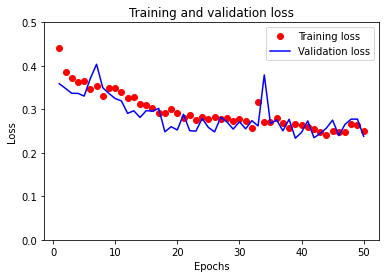

In [58]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'ro', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.ylim((0,0.5))
plt.legend()

plt.show()

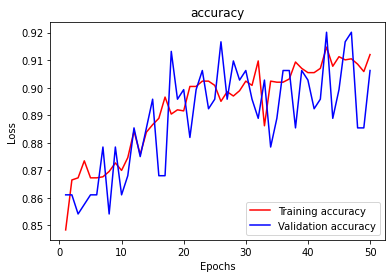

In [59]:
accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']


plt.plot(epochs, accuracy, 'r', label='Training accuracy')
plt.plot(epochs, val_accuracy, 'b', label='Validation accuracy')
plt.title('accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

plt.show()

In [60]:
pred = model.predict(np.expand_dims(x_test[14], axis=0))
print(pred)
print(y_test[14])

[[0.89114046 0.10885953]]
[0. 1.]


In [61]:
print(y_test[10:20])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]
